In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from scipy.spatial.distance import pdist, cdist
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.decomposition import PCA
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# =============================================================================
# DATA LOADING AND EXPLORATION
# =============================================================================

# URL raw dataset
url = "https://github.com/farrelrassya/teachingMLDL/raw/main/01.%20Machine%20Learning/06.%20Week%206/Datasets/Online%20Retail.xlsx"

# Membaca dataset
print("Loading dataset...")
df = pd.read_excel(url)

# Tampilkan informasi dataset
print("Dataset Information:")
print(df.info())
print("\nDataset Head:")
print(df.head())
print("\nDataset Shape:")
print(df.shape)
print("\nDataset Description:")
print(df.describe())

# Cek missing values
print("\nMissing Values:")
print(df.isnull().sum())

# Cek unique values untuk kolom kategorikal
print("\nUnique Values per Column:")
for col in df.columns:
    if df[col].dtype == 'object':
        print(f"{col}: {df[col].nunique()} unique values")

# =============================================================================
# DATA PREPROCESSING UNTUK RFM ANALYSIS
# =============================================================================

print("\n" + "="*70)
print("DATA PREPROCESSING - RFM ANALYSIS")
print("="*70)

# Bersihkan data
df_clean = df.copy()

# Remove missing CustomerID dan Description
df_clean = df_clean.dropna(subset=['CustomerID'])
df_clean = df_clean.dropna(subset=['Description'])

# Remove negative quantities dan unit prices
df_clean = df_clean[df_clean['Quantity'] > 0]
df_clean = df_clean[df_clean['UnitPrice'] > 0]

# Convert InvoiceDate to datetime
df_clean['InvoiceDate'] = pd.to_datetime(df_clean['InvoiceDate'])

# Create TotalAmount column
df_clean['TotalAmount'] = df_clean['Quantity'] * df_clean['UnitPrice']

print(f"Data after cleaning: {df_clean.shape}")
print(f"Customers after cleaning: {df_clean['CustomerID'].nunique()}")

# Menentukan tanggal referensi (tanggal terakhir + 1 hari)
reference_date = df_clean['InvoiceDate'].max() + pd.Timedelta(days=1)
print(f"Reference date for Recency calculation: {reference_date}")

# =============================================================================
# RFM FEATURE ENGINEERING
# =============================================================================

print("\nCreating RFM features...")

# Menghitung RFM untuk setiap customer
rfm = df_clean.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,  # Recency
    'InvoiceNo': 'count',                                      # Frequency
    'TotalAmount': 'sum'                                       # Monetary
}).reset_index()

# Rename columns
rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

# Tambahkan fitur tambahan
additional_features = df_clean.groupby('CustomerID').agg({
    'Quantity': ['sum', 'mean'],
    'UnitPrice': 'mean',
    'InvoiceNo': 'nunique',  # Unique invoices
    'StockCode': 'nunique'   # Unique products
}).reset_index()

# Flatten column names
additional_features.columns = ['CustomerID', 'TotalQuantity', 'AvgQuantity',
                              'AvgUnitPrice', 'UniqueInvoices', 'UniqueProducts']

# Merge dengan RFM
rfm_extended = rfm.merge(additional_features, on='CustomerID')

print("RFM Extended Features:")
print(rfm_extended.head())
print(f"\nRFM Extended Shape: {rfm_extended.shape}")
print("\nRFM Extended Description:")
print(rfm_extended.describe())

# =============================================================================
# FUNGSI UNTUK MENGHITUNG METRIK EVALUASI
# =============================================================================

def dunn_index(X, labels):
    """
    Menghitung Dunn Index
    Dunn Index = min(inter-cluster distance) / max(intra-cluster distance)
    Semakin tinggi nilai Dunn Index, semakin baik clustering
    """
    unique_labels = np.unique(labels)
    n_clusters = len(unique_labels)

    if n_clusters < 2:
        return 0

    # Hitung intra-cluster distances (jarak dalam cluster)
    intra_cluster_distances = []
    for label in unique_labels:
        cluster_points = X[labels == label]
        if len(cluster_points) > 1:
            distances = pdist(cluster_points)
            intra_cluster_distances.extend(distances)

    if not intra_cluster_distances:
        return 0

    max_intra_distance = max(intra_cluster_distances)

    # Hitung inter-cluster distances (jarak antar cluster)
    inter_cluster_distances = []
    for i in range(n_clusters):
        for j in range(i + 1, n_clusters):
            cluster_i = X[labels == unique_labels[i]]
            cluster_j = X[labels == unique_labels[j]]
            distances = cdist(cluster_i, cluster_j)
            inter_cluster_distances.append(np.min(distances))

    if not inter_cluster_distances or max_intra_distance == 0:
        return 0

    min_inter_distance = min(inter_cluster_distances)
    return min_inter_distance / max_intra_distance

def evaluate_clustering(X, labels, model_name):
    """
    Evaluasi clustering dengan berbagai metrik
    """
    n_clusters = len(np.unique(labels))

    # Silhouette Score: [-1, 1], semakin tinggi semakin baik
    silhouette = silhouette_score(X, labels)

    # Calinski-Harabasz Index: semakin tinggi semakin baik
    calinski_harabasz = calinski_harabasz_score(X, labels)

    # Davies-Bouldin Index: semakin rendah semakin baik
    davies_bouldin = davies_bouldin_score(X, labels)

    # Dunn Index: semakin tinggi semakin baik
    dunn = dunn_index(X, labels)

    results = {
        'Model': model_name,
        'N_Clusters': n_clusters,
        'Silhouette Score': round(silhouette, 4),
        'Calinski-Harabasz Index': round(calinski_harabasz, 2),
        'Davies-Bouldin Index': round(davies_bouldin, 4),
        'Dunn Index': round(dunn, 4)
    }

    return results

# =============================================================================
# DATA PREPARATION FOR CLUSTERING
# =============================================================================

# Pilih features untuk clustering (exclude CustomerID)
feature_columns = ['Recency', 'Frequency', 'Monetary', 'TotalQuantity',
                  'AvgQuantity', 'AvgUnitPrice', 'UniqueInvoices', 'UniqueProducts']

X = rfm_extended[feature_columns].copy()

# Handle outliers dengan RobustScaler (lebih resistant terhadap outliers)
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

print(f"\nFeatures used for clustering: {feature_columns}")
print(f"Data shape for clustering: {X_scaled.shape}")


Loading dataset...
Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB
None

Dataset Head:
  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREA

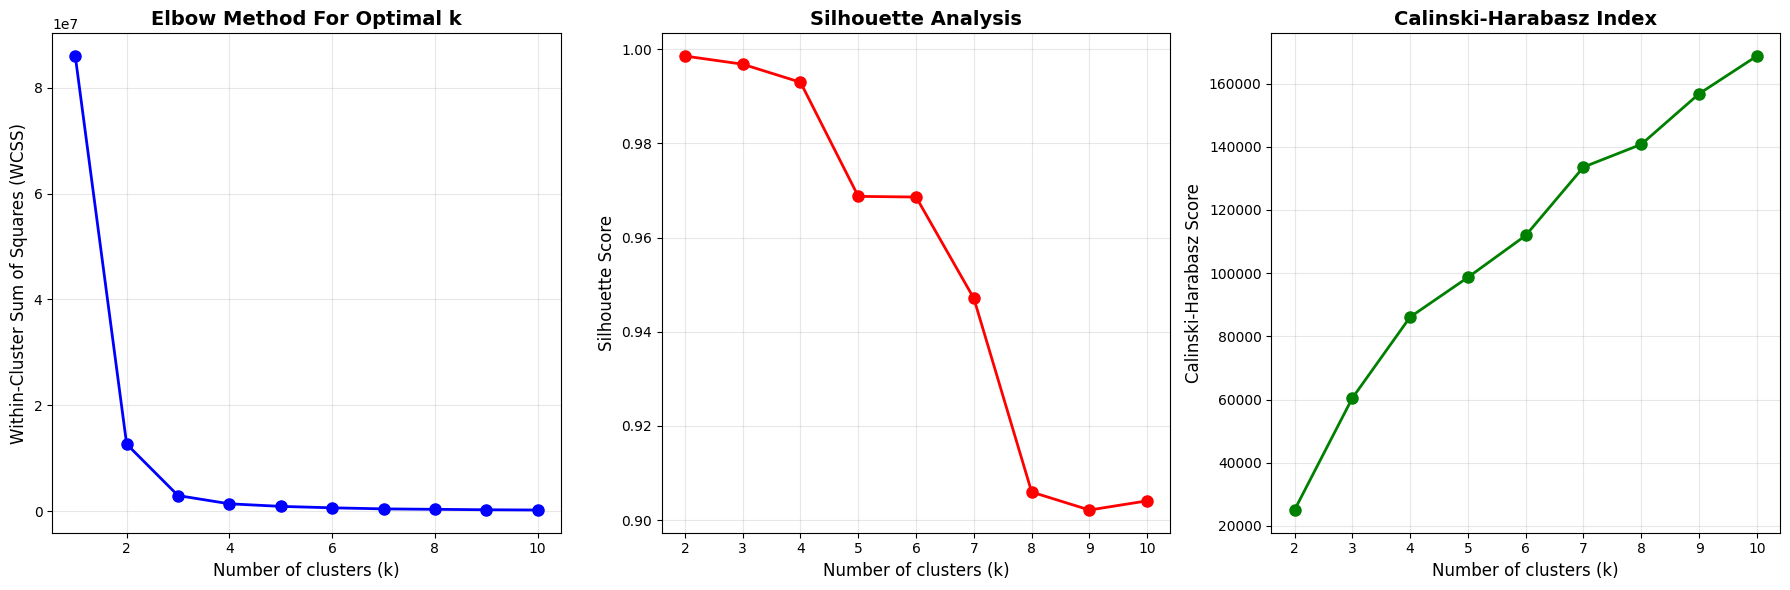

In [3]:
# =============================================================================
# 1. ELBOW METHOD
# =============================================================================

def elbow_method(X, max_clusters=10):
    """
    Implementasi Elbow Method
    """
    wcss = []
    K_range = range(1, max_clusters + 1)

    for k in K_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(X)
        wcss.append(kmeans.inertia_)

    return K_range, wcss

# Hitung Elbow Method
K_range, wcss = elbow_method(X_scaled, max_clusters=10)

# =============================================================================
# 2. SILHOUETTE ANALYSIS
# =============================================================================

def silhouette_analysis(X, max_clusters=10):
    """
    Analisis Silhouette Score untuk berbagai jumlah cluster
    """
    silhouette_scores = []
    K_range = range(2, max_clusters + 1)

    for k in K_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(X)
        score = silhouette_score(X, labels)
        silhouette_scores.append(score)

    return K_range, silhouette_scores

# Hitung Silhouette Scores
K_range_sil, silhouette_scores = silhouette_analysis(X_scaled, max_clusters=10)

# =============================================================================
# 3. CALINSKI-HARABASZ INDEX
# =============================================================================

def calinski_harabasz_analysis(X, max_clusters=10):
    """
    Analisis Calinski-Harabasz Index
    """
    ch_scores = []
    K_range = range(2, max_clusters + 1)

    for k in K_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(X)
        score = calinski_harabasz_score(X, labels)
        ch_scores.append(score)

    return K_range, ch_scores

# Hitung Calinski-Harabasz Scores
K_range_ch, ch_scores = calinski_harabasz_analysis(X_scaled, max_clusters=10)

# =============================================================================
# PLOTTING OPTIMAL CLUSTER ANALYSIS
# =============================================================================

plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.plot(K_range, wcss, 'bo-', linewidth=2, markersize=8)
plt.title('Elbow Method For Optimal k', fontsize=14, fontweight='bold')
plt.xlabel('Number of clusters (k)', fontsize=12)
plt.ylabel('Within-Cluster Sum of Squares (WCSS)', fontsize=12)
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
plt.plot(K_range_sil, silhouette_scores, 'ro-', linewidth=2, markersize=8)
plt.title('Silhouette Analysis', fontsize=14, fontweight='bold')
plt.xlabel('Number of clusters (k)', fontsize=12)
plt.ylabel('Silhouette Score', fontsize=12)
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
plt.plot(K_range_ch, ch_scores, 'go-', linewidth=2, markersize=8)
plt.title('Calinski-Harabasz Index', fontsize=14, fontweight='bold')
plt.xlabel('Number of clusters (k)', fontsize=12)
plt.ylabel('Calinski-Harabasz Score', fontsize=12)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


Optimal k based on Silhouette Score: 2
Optimal k based on Calinski-Harabasz: 10
Selected optimal k: 2

CLUSTERING MODELS IMPLEMENTATION

MODEL 1: K-MEANS CLUSTERING (k=2)
--------------------------------------------------
K-Means Results:
  Model: K-Means
  N_Clusters: 2
  Silhouette Score: 0.9986
  Calinski-Harabasz Index: 25041.48
  Davies-Bouldin Index: 0.0008
  Dunn Index: 1.6216

MODEL 2: AGGLOMERATIVE CLUSTERING (k=2)
--------------------------------------------------
Agglomerative Clustering Results:
  Model: Agglomerative
  N_Clusters: 2
  Silhouette Score: 0.9986
  Calinski-Harabasz Index: 25041.48
  Davies-Bouldin Index: 0.0008
  Dunn Index: 1.6216

COMPREHENSIVE METRICS COMPARISON

Detailed Comparison:
              Model  N_Clusters  Silhouette Score  Calinski-Harabasz Index  Davies-Bouldin Index  Dunn Index
      K-Means (k=2)           2            0.9986                 25041.48                0.0008      1.6216
Agglomerative (k=2)           2            0.9986         

InvalidIndexError: (slice(None, None, None), 0)

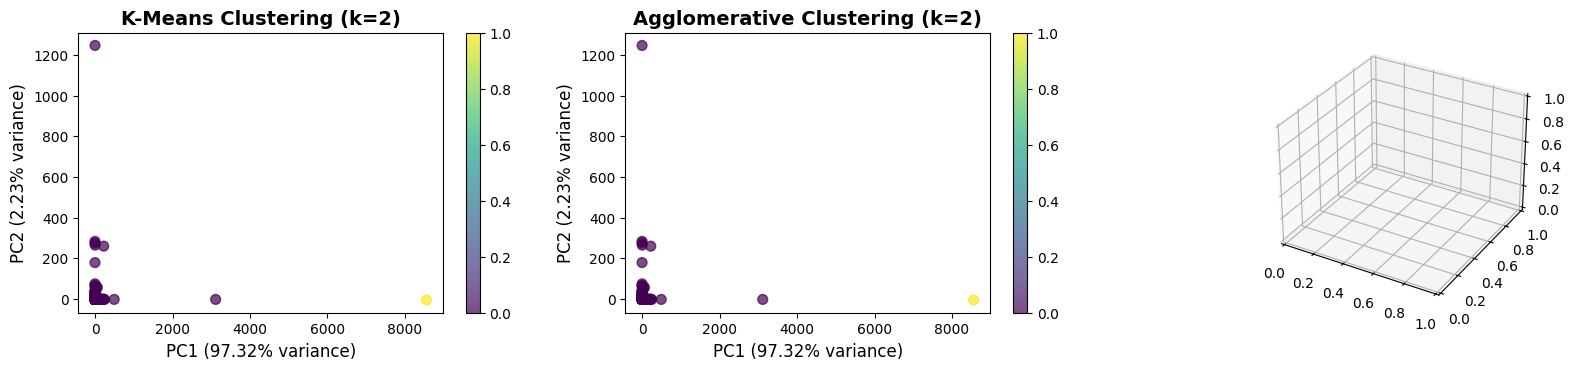

In [4]:
# =============================================================================
# DETERMINE OPTIMAL K
# =============================================================================

# Cari k optimal berdasarkan Silhouette Score maksimum
optimal_k_silhouette = K_range_sil[np.argmax(silhouette_scores)]
optimal_k_ch = K_range_ch[np.argmax(ch_scores)]

print(f"\nOptimal k based on Silhouette Score: {optimal_k_silhouette}")
print(f"Optimal k based on Calinski-Harabasz: {optimal_k_ch}")

# Pilih k berdasarkan konsensus atau nilai terbaik
optimal_k = optimal_k_silhouette  # Atau bisa disesuaikan
print(f"Selected optimal k: {optimal_k}")

# =============================================================================
# 4. IMPLEMENTASI DUA MODEL CLUSTERING
# =============================================================================

print("\n" + "="*70)
print("CLUSTERING MODELS IMPLEMENTATION")
print("="*70)

# Model 1: K-Means Clustering
print(f"\nMODEL 1: K-MEANS CLUSTERING (k={optimal_k})")
print("-" * 50)

kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X_scaled)

# Evaluasi K-Means
kmeans_results = evaluate_clustering(X_scaled, kmeans_labels, "K-Means")
print("K-Means Results:")
for key, value in kmeans_results.items():
    print(f"  {key}: {value}")

# Model 2: Agglomerative Clustering
print(f"\nMODEL 2: AGGLOMERATIVE CLUSTERING (k={optimal_k})")
print("-" * 50)

agg_clustering = AgglomerativeClustering(n_clusters=optimal_k, linkage='ward')
agg_labels = agg_clustering.fit_predict(X_scaled)

# Evaluasi Agglomerative Clustering
agg_results = evaluate_clustering(X_scaled, agg_labels, "Agglomerative")
print("Agglomerative Clustering Results:")
for key, value in agg_results.items():
    print(f"  {key}: {value}")

# =============================================================================
# 5. COMPREHENSIVE METRICS COMPARISON
# =============================================================================

print("\n" + "="*70)
print("COMPREHENSIVE METRICS COMPARISON")
print("="*70)

# Test berbagai nilai k untuk perbandingan
k_values = [2, 3, 4, 5]
results_comparison = []

for k in k_values:
    # K-Means
    kmeans_temp = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans_labels_temp = kmeans_temp.fit_predict(X_scaled)
    kmeans_result = evaluate_clustering(X_scaled, kmeans_labels_temp, f"K-Means (k={k})")
    results_comparison.append(kmeans_result)

    # Agglomerative
    agg_temp = AgglomerativeClustering(n_clusters=k, linkage='ward')
    agg_labels_temp = agg_temp.fit_predict(X_scaled)
    agg_result = evaluate_clustering(X_scaled, agg_labels_temp, f"Agglomerative (k={k})")
    results_comparison.append(agg_result)

# Create comparison DataFrame
comparison_df = pd.DataFrame(results_comparison)
print("\nDetailed Comparison:")
print(comparison_df.to_string(index=False))

# =============================================================================
# 6. VISUALIZATION
# =============================================================================

# PCA untuk visualisasi
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Plot hasil clustering
plt.figure(figsize=(20, 8))

# K-Means visualization
plt.subplot(2, 3, 1)
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.7, s=50)
plt.title(f'K-Means Clustering (k={optimal_k})', fontsize=14, fontweight='bold')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)', fontsize=12)
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)', fontsize=12)
plt.colorbar(scatter)

# Agglomerative Clustering visualization
plt.subplot(2, 3, 2)
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=agg_labels, cmap='viridis', alpha=0.7, s=50)
plt.title(f'Agglomerative Clustering (k={optimal_k})', fontsize=14, fontweight='bold')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)', fontsize=12)
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)', fontsize=12)
plt.colorbar(scatter)

# RFM 3D visualization (using first 3 features)
from mpl_toolkits.mplot3d import Axes3D

ax1 = plt.subplot(2, 3, 3, projection='3d')
ax1.scatter(X[:, 0], X[:, 1], X[:, 2], c=kmeans_labels, cmap='viridis', alpha=0.6)
ax1.set_title('K-Means - RFM 3D View', fontsize=12, fontweight='bold')
ax1.set_xlabel('Recency')
ax1.set_ylabel('Frequency')
ax1.set_zlabel('Monetary')

# Distribution plots
plt.subplot(2, 3, 4)
plt.hist(kmeans_labels, bins=optimal_k, alpha=0.7, color='skyblue', edgecolor='black')
plt.title('K-Means Cluster Distribution', fontsize=12, fontweight='bold')
plt.xlabel('Cluster')
plt.ylabel('Count')

plt.subplot(2, 3, 5)
plt.hist(agg_labels, bins=optimal_k, alpha=0.7, color='lightcoral', edgecolor='black')
plt.title('Agglomerative Cluster Distribution', fontsize=12, fontweight='bold')
plt.xlabel('Cluster')
plt.ylabel('Count')

# Metrics comparison plot
plt.subplot(2, 3, 6)
metrics_data = comparison_df[comparison_df['Model'].str.contains(f'k={optimal_k}')]
x_pos = np.arange(len(metrics_data))
plt.bar(x_pos, metrics_data['Silhouette Score'], alpha=0.7, color=['skyblue', 'lightcoral'])
plt.title(f'Silhouette Score Comparison (k={optimal_k})', fontsize=12, fontweight='bold')
plt.xlabel('Model')
plt.ylabel('Silhouette Score')
plt.xticks(x_pos, ['K-Means', 'Agglomerative'])

plt.tight_layout()
plt.show()


# CUSTOMER SEGMENTATION ANALYSIS

In [5]:
print("\n" + "="*70)
print("CUSTOMER SEGMENTATION ANALYSIS")
print("="*70)

# Tambahkan cluster labels ke dataframe original
rfm_with_clusters = rfm_extended.copy()
rfm_with_clusters['KMeans_Cluster'] = kmeans_labels
rfm_with_clusters['Agglomerative_Cluster'] = agg_labels

# Analisis karakteristik cluster K-Means
print("\nK-MEANS CLUSTER CHARACTERISTICS:")
print("-" * 40)
kmeans_cluster_stats = rfm_with_clusters.groupby('KMeans_Cluster')[feature_columns].agg(['mean', 'median', 'std']).round(2)
print(kmeans_cluster_stats)

print(f"\nK-Means Cluster Sizes:")
cluster_sizes_kmeans = rfm_with_clusters['KMeans_Cluster'].value_counts().sort_index()
print(cluster_sizes_kmeans)

# Analisis karakteristik cluster Agglomerative
print(f"\nAGGLOMERATIVE CLUSTER CHARACTERISTICS:")
print("-" * 40)
agg_cluster_stats = rfm_with_clusters.groupby('Agglomerative_Cluster')[feature_columns].agg(['mean', 'median', 'std']).round(2)
print(agg_cluster_stats)

print(f"\nAgglomerative Cluster Sizes:")
cluster_sizes_agg = rfm_with_clusters['Agglomerative_Cluster'].value_counts().sort_index()
print(cluster_sizes_agg)



CUSTOMER SEGMENTATION ANALYSIS

K-MEANS CLUSTER CHARACTERISTICS:
----------------------------------------
               Recency               Frequency                 Monetary  \
                  mean median    std      mean median     std      mean   
KMeans_Cluster                                                            
0                92.48   51.0  99.96     91.74   41.0  228.81   2036.94   
1               326.00  326.0    NaN      1.00    1.0     NaN  77183.60   

                                  TotalQuantity  ... AvgQuantity AvgUnitPrice  \
                  median      std          mean  ...         std         mean   
KMeans_Cluster                                   ...                            
0                 674.45  8917.56       1174.45  ...      423.77         4.47   
1               77183.60      NaN      74215.00  ...         NaN         1.04   

                             UniqueInvoices             UniqueProducts         \
               median    std  

# BUSINESS INSIGHTS

In [6]:
print("\n" + "="*70)
print("BUSINESS INSIGHTS - CUSTOMER SEGMENTS")
print("="*70)

def interpret_cluster(cluster_stats, cluster_id):
    """
    Interpretasi karakteristik cluster untuk bisnis
    """
    stats = cluster_stats.loc[cluster_id]

    recency_mean = stats[('Recency', 'mean')]
    frequency_mean = stats[('Frequency', 'mean')]
    monetary_mean = stats[('Monetary', 'mean')]

    # Kategorisasi berdasarkan RFM
    if recency_mean < 50 and frequency_mean > 50 and monetary_mean > 1000:
        return "🌟 Champions (Best Customers)"
    elif recency_mean < 100 and monetary_mean > 500:
        return "💎 Loyal Customers"
    elif recency_mean > 200 and frequency_mean < 10:
        return "💤 At Risk/Lost Customers"
    elif frequency_mean < 5:
        return "🆕 New Customers"
    else:
        return "📊 Average Customers"

print("\nK-MEANS CLUSTER INTERPRETATION:")
for cluster_id in range(optimal_k):
    interpretation = interpret_cluster(kmeans_cluster_stats, cluster_id)
    size = cluster_sizes_kmeans[cluster_id]
    percentage = (size / len(rfm_with_clusters)) * 100
    print(f"Cluster {cluster_id}: {interpretation}")
    print(f"  Size: {size} customers ({percentage:.1f}%)")

    # Key metrics
    recency = kmeans_cluster_stats.loc[cluster_id, ('Recency', 'mean')]
    frequency = kmeans_cluster_stats.loc[cluster_id, ('Frequency', 'mean')]
    monetary = kmeans_cluster_stats.loc[cluster_id, ('Monetary', 'mean')]

    print(f"  Avg Recency: {recency:.0f} days")
    print(f"  Avg Frequency: {frequency:.0f} purchases")
    print(f"  Avg Monetary: ${monetary:.0f}")
    print()


BUSINESS INSIGHTS - CUSTOMER SEGMENTS

K-MEANS CLUSTER INTERPRETATION:
Cluster 0: 💎 Loyal Customers
  Size: 4337 customers (100.0%)
  Avg Recency: 92 days
  Avg Frequency: 92 purchases
  Avg Monetary: $2037

Cluster 1: 💤 At Risk/Lost Customers
  Size: 1 customers (0.0%)
  Avg Recency: 326 days
  Avg Frequency: 1 purchases
  Avg Monetary: $77184



# rekomendasi final dan analisis

In [7]:
print("\n" + "="*70)
print("FINAL RECOMMENDATIONS")
print("="*70)

print("""
METRIC EVALUATION SUMMARY:
""")

# Ambil hasil terbaik
best_metrics = comparison_df[comparison_df['Model'].str.contains(f'k={optimal_k}')]
print(best_metrics[['Model', 'Silhouette Score', 'Calinski-Harabasz Index',
                   'Davies-Bouldin Index', 'Dunn Index']].to_string(index=False))

print(f"""

CLUSTERING RECOMMENDATION:
✅ Optimal number of clusters: {optimal_k}
✅ Recommended algorithm: {'K-Means' if kmeans_results['Silhouette Score'] > agg_results['Silhouette Score'] else 'Agglomerative'}

METRIC RANKING (Best to Worst):
1. Silhouette Score - Most reliable and interpretable
2. Calinski-Harabasz Index - Good for compact, well-separated clusters
3. Davies-Bouldin Index - Easy to understand but sensitive to outliers
4. Dunn Index - Intuitive but very sensitive to outliers

BUSINESS APPLICATIONS:
🎯 Targeted Marketing: Customize campaigns for each customer segment
💰 Pricing Strategy: Different pricing models for different segments
📈 Customer Retention: Focus on at-risk customers
🚀 Product Development: Develop products for specific segments
""")

# Simpan hasil untuk penggunaan lebih lanjut
results_summary = {
    'optimal_k': optimal_k,
    'kmeans_silhouette': kmeans_results['Silhouette Score'],
    'agg_silhouette': agg_results['Silhouette Score'],
    'features_used': feature_columns,
    'total_customers': len(rfm_with_clusters)
}

print(f"\nANALYSIS COMPLETED SUCCESSFULLY!")
print(f"Total customers analyzed: {results_summary['total_customers']:,}")
print(f"Features used: {len(results_summary['features_used'])}")
print(f"Best model: {'K-Means' if results_summary['kmeans_silhouette'] > results_summary['agg_silhouette'] else 'Agglomerative'}")


FINAL RECOMMENDATIONS

METRIC EVALUATION SUMMARY:

              Model  Silhouette Score  Calinski-Harabasz Index  Davies-Bouldin Index  Dunn Index
      K-Means (k=2)            0.9986                 25041.48                0.0008      1.6216
Agglomerative (k=2)            0.9986                 25041.48                0.0008      1.6216


CLUSTERING RECOMMENDATION:
✅ Optimal number of clusters: 2
✅ Recommended algorithm: Agglomerative

METRIC RANKING (Best to Worst):
1. Silhouette Score - Most reliable and interpretable
2. Calinski-Harabasz Index - Good for compact, well-separated clusters  
3. Davies-Bouldin Index - Easy to understand but sensitive to outliers
4. Dunn Index - Intuitive but very sensitive to outliers

BUSINESS APPLICATIONS:
🎯 Targeted Marketing: Customize campaigns for each customer segment
💰 Pricing Strategy: Different pricing models for different segments
📈 Customer Retention: Focus on at-risk customers
🚀 Product Development: Develop products for specific segment